In [1]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scipy.spatial.distance import cosine
import pandas as pd
import torch
import torch.nn as nn
import torch.hub
import torchvision.models as models
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Directory containing the images
images_directory = '/content/drive/MyDrive/test_dataset'
# "..\corpus_lipade\presse\photos\jpg"

Mounted at /content/drive


# Pre processing

In [3]:
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
    return input_batch

def get_features(image_batch, model):
    if torch.cuda.is_available():
        image_batch = image_batch.to('cuda')
    with torch.no_grad():
        features = model(image_batch)
    return features.cpu().numpy()


def compare_images(feature1, feature2, threshold=0.88):
    similarity = 1 - cosine(feature1.flatten(), feature2.flatten())
    return similarity > threshold

# Load the finetuned ResNet model

In [4]:
# Loading fine-tuned ResNet model's state dictionary
model_path = '/content/drive/MyDrive/Resnet_Finetuned/resnet_model_epoch_50_loss_5.71.pth'
state_dict = torch.load(model_path)

# Instance of the ResNet model
model = models.resnet152(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 71)  #71 is num of classes
model.load_state_dict(state_dict)

# Setting the model to evaluation mode
model.eval()
if torch.cuda.is_available():
    model.to('cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Extracting features of all images

In [5]:
dataset_features = {}
for image_name in os.listdir(images_directory):
    if image_name.endswith(".jpg"):
        image_path = os.path.join(images_directory, image_name)
        image_batch = preprocess_image(image_path)
        features = get_features(image_batch, model)
        dataset_features[image_name] = features

# Compare each image to every other image

Here we decided to crop at top 9 images and use a threshold of 0.88

In [6]:
def find_similar_images(query_features, dataset_features, threshold=0.88, top_n=9):
    similar_images = []
    for img_name, features in dataset_features.items():
        similarity = 1 - cosine(query_features.flatten(), features.flatten())
        if similarity > threshold:
            similar_images.append((img_name, similarity))
    similar_images.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity
    return [img_name for img_name, _ in similar_images[:top_n]]

# Image retrieval using fine-tuned model

Query Image:


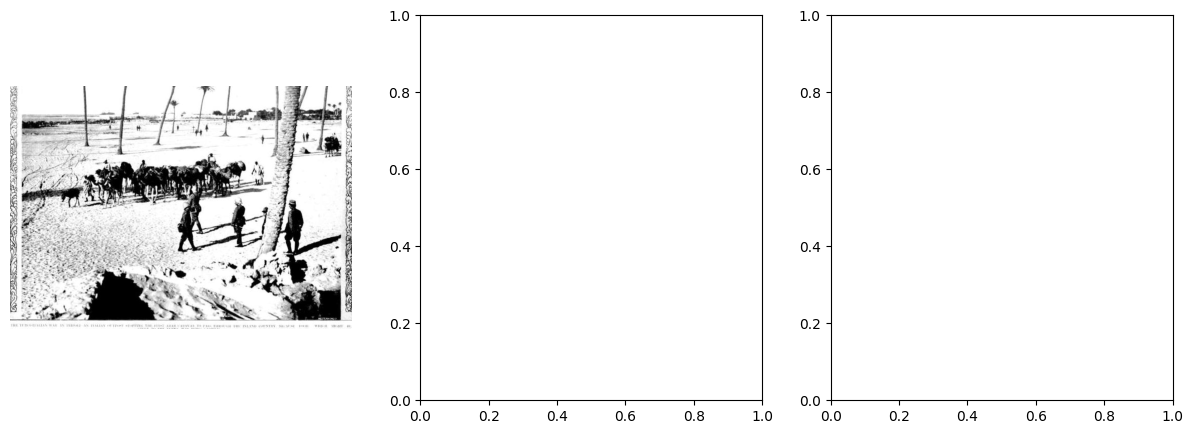

Similar Images:


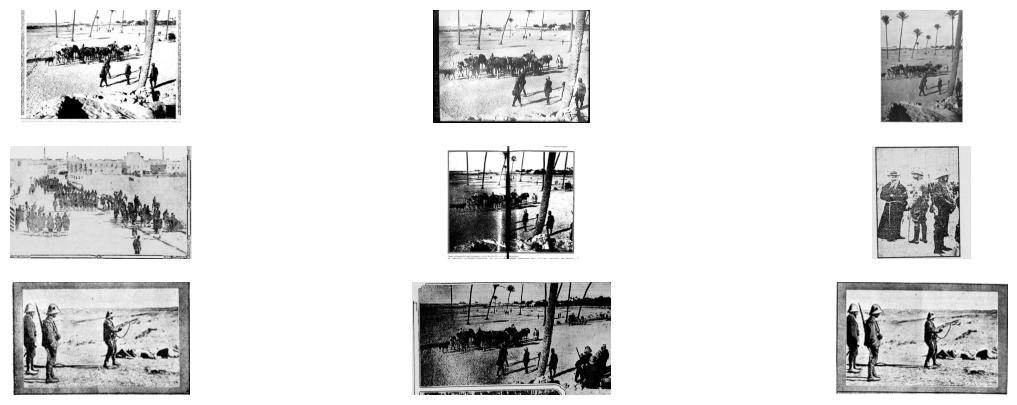

In [7]:
# Randomly selecting a ref image from the test images_directory
query_image_name = random.choice([img_name for img_name in os.listdir(images_directory) if img_name.endswith(".jpg")])
query_image_path = os.path.join(images_directory, query_image_name)


# Preprocess and extract its features
query_image_batch = preprocess_image(query_image_path)
query_features = get_features(query_image_batch, model)

# Image retrieval
similar_images = find_similar_images(query_features, dataset_features, threshold=0.88)


# Function to display images
def display_images(image_paths, columns=3):
    num_images = len(image_paths)
    rows = (num_images + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 5))
    axes = axes.ravel()
    for i in range(min(num_images, columns * rows)):
        img = Image.open(image_paths[i]).convert('L')
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()


# Display the query image
print("Query Image:")
display_images([query_image_path])

# Display similar images found with model
if similar_images:
    print("Similar Images:")
    similar_image_paths = [os.path.join(images_directory, img_name) for img_name in similar_images]
    display_images(similar_image_paths)
else:
    print("No similar images found.")